In [1]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import scipy
from scipy.stats import permutation_test # requires python 3.8 and updated scipy version
import matplotlib.pyplot as plt
from numpy.random import permutation


Sources: 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.permutation_test.html

https://en.wikipedia.org/wiki/Permutation_test

https://nblok306.ftn.uns.ac.rs/~zoran/A/knjige/Chihara2011.pdf

https://matthew-brett.github.io/cfd2020/permutation/permutation_and_t_test.html

https://www.amazon.com/exec/obidos/ASIN/0943126444/jmir-20?dev-t=mason-wrapper%26camp=2025%26link_code=xm2

https://support.jmir.org/hc/en-us/articles/360000002012

https://github.com/qbarthelemy/PyPermut


- Null hypothesis: Two samples belong to the same distribution

- Alternative hypothesis: Model B (ML model) performs better than Model A (NEWS)

We will compute the p-value based on the differences between the samples. The p-value indicates the probability that pure chance would lead to the same observed difference between the two samples. If the p-value is below a certain threshold assumed to be statistically significant, then we reject the null hypothesis and accept the alternative hypothesis. If the p-value is above the threshold, then we cannot reject the null hypothesis. 


## [1] Simulate dataset

In [2]:
# Create a sample of groundtruth labels
y = [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,]

# Simulate predictions of model A (Assume NEWS)
y_a = [0.8, 0.7, 0.2, 0.8, 0.15, 0.1, 0.2, 0.9, 0.8, 0.7, 0.2, 0.8, 0.15, 0.1, 0.2, 0.9, 0.8, 0.7, 0.2, 0.8, 0.15, 0.1, 0.2, 0.9]
auroc_a = metrics.roc_auc_score(y, y_a)
print(auroc_a)

# Simulate predictions of model B (Assume XGboost)
y_b = [0, 0.5, 0.7, 0.9, 0.4, 0.2, 0.02, 0.01, 0, 0.5, 0.7, 0.9, 0.4, 0.2, 0.02, 0.01, 0, 0.5, 0.7, 0.9, 0.4, 0.2, 0.02, 0.01]
auroc_b = metrics.roc_auc_score(y, y_b)
print(auroc_b)

0.71875
0.75


In [4]:
def seed_everything(seed=42):
    """
    Function to seed all RNGs. 
    Taken from #https://stackoverflow.com/questions/57416925/best-practices-for-generating-a-random-seeds-to-seed-pytorch

    Args:
        seed: RNG seed. Defaults to 42.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

In [5]:
import pickle
from models import XGBoost, NEWS, LogisticRegression

path = './results/'

seed_everything(32)

# with open(path + '/targets.pkl', 'rb') as f:
#     targets = pickle.load(f)
labely = ['y_true']

# train = pd.read_csv(path + '/train' + '.csv', encoding="ISO-8859-1")
# val = pd.read_csv(path + '/val' + '.csv', encoding="ISO-8859-1")
test = pd.read_csv('splits/testH24' + '.csv', encoding="ISO-8859-1")

# X_train = train[targets]
# y_train = train[labely]
# X_val = val[targets]
# y_val = val[labely]
# X_test= test[targets]
# y_test= test[labely]

# X_train_col_mean = np.nanmean(X_train, axis=0)
# X_val_col_mean = np.nanmean(X_val, axis=0)
# X_test_col_mean = np.nanmean(X_val, axis=0)

# X_train = np.where(np.isnan(X_train), X_train_col_mean, X_train)
# X_val = np.where(np.isnan(X_val), X_val_col_mean, X_val)
# X_test = np.where(np.isnan(X_test), X_test_col_mean, X_test)


# Create a sample of groundtruth labels
y = test[labely]
y = y.values[:,0]

metric = 'auprc'

# modelA = LogisticRegression()
# modelA.train(X_train, y_train, X_val, y_val, metric='auprc')
#Simulate predictions of model A (Assume NEWS)
with open(path + "newsH24.pkl", "rb") as f:
    y_a = pickle.load(f)
#y_a = modelA.model.predict_proba(X_test)[:,1]
auroc_a = metrics.roc_auc_score(y, y_a)
print(auroc_a)


with open(path + "fcnnH24.pkl", "rb") as f:
    y_b = pickle.load(f)
auroc_b = metrics.roc_auc_score(y, y_b)
print(auroc_b)

ModuleNotFoundError: No module named 'models'

## [2] Calculate confidence intervals for metric using the bootstrap method

In [145]:
def boostrap(y_true, y_pred, metric='auroc'):
    n_iterations = 1000
    Test_AUC=[]
    Test_AUPRC=[]

    if metric == 'auroc':
        score = roc_auc_score
    else:
        score = average_precision_score
    auc_true = score(y_true, y_pred)
#     AUPRC_true = average_precision_score(test[outcome],predictions_df["avg"])
    
    test = pd.DataFrame({'y': y_true, 'pred': y_pred})


    for i in range(n_iterations):

        test_resampled = test.sample(frac=1, replace=True)

        auc = score(test_resampled['y'], test_resampled['pred'])
        Test_AUC.append(auc)
        #avg = average_precision_score(test_resampled[outcome], test_resampled["prediction"])
        #Test_AUPRC.append(avg)

    return Test_AUC, auc_true


def compute_confidence_intervals(list_,true_value):
    """This function calcualted the 95% Confidence Intervals"""
    delta = (true_value - list_)
    list(np.sort(delta))
    delta_lower = np.percentile(delta, 97.5)
    delta_upper = np.percentile(delta, 2.5)

    upper = true_value - delta_upper
    lower = true_value - delta_lower
    print(f"CI 95% {round(true_value, 3)} ( {round(lower, 3)} , {round(upper, 3)} )")

    return(upper,lower)

In [146]:
# boostrap model A
test_auc_A, auc_true_A = boostrap(y, y_a, metric=metric)

# bootstrap model B
test_auc_B, auc_true_B = boostrap(y, y_b, metric=metric)


In [147]:
upp_a, lower_a = compute_confidence_intervals(test_auc_A, auc_true_A)

CI 95% 0.133 ( 0.117 , 0.152 )


In [148]:
upp_b, lower_b = compute_confidence_intervals(test_auc_B, auc_true_B)

CI 95% 0.2 ( 0.178 , 0.225 )


## [3] Compute the difference between the two samples using boostrapping + CI

In [149]:
def boostrap_diff(y_true, y_pred_A, y_pred_B, metric = 'auroc'):
    n_iterations = 1000
    
    Test_AUC_diff=[]
    
    test = pd.DataFrame({'y': y_true, 'pred_A': y_pred_A, 'pred_B': y_pred_B})

    if metric == 'auroc':
        score = roc_auc_score
    else:
        score = average_precision_score
    
    auc_true_A = score(y_true, y_pred_A)
    auc_true_B = score(y_true, y_pred_B)

    auroc_diff = auc_true_B - auc_true_A 

    for i in range(n_iterations):

        test_resampled = test.sample(frac=1, replace=True)

        auc_A = score(test_resampled['y'], test_resampled['pred_A'])
        auc_B = score(test_resampled['y'], test_resampled['pred_B'])
        
        diff = auc_B - auc_A
        
        Test_AUC_diff.append(diff)

    return Test_AUC_diff, auroc_diff

In [150]:
# Compute the difference in AUROC and CI for the two samples using the boostrap method
test_diff, true_diff =  boostrap_diff(y, y_a, y_b, metric=metric)
upp_diff, lower_diff = compute_confidence_intervals(test_diff, true_diff)

CI 95% 0.067 ( 0.052 , 0.085 )


## [4] P-value using one-sided permutation test

In [151]:
# Concatenate the two samples
pooled_pred = np.append(y_a, y_b)
pooled_true = np.append(y, y)

n_iters = 10000
fake_differences = np.zeros(n_iters)

if metric == 'auroc':
    score = roc_auc_score
else:
    score = average_precision_score

for i in np.arange(n_iters):
    #print(i)
    # Obtain permutation for both predictions and groundtruth labels
    perm = permutation(len(pooled_pred))
    y_true = pooled_true[perm]
    y_pred = pooled_pred[perm]
    
    # Compute the difference and add it to the array of differences
    fake_differences[i] = score(y_true[:len(y_a)], y_pred[:len(y_a)]) - score(y_true[len(y_a):], y_pred[len(y_a):])
    
    

Text(0.5, 1.0, 'Sampling distribution of difference of metric')

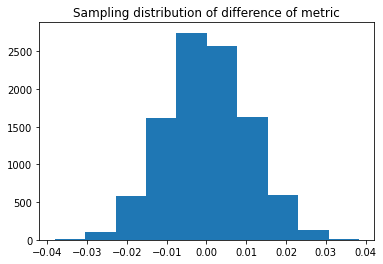

In [152]:
plt.hist(fake_differences)
plt.title('Sampling distribution of difference of metric')


In [153]:
permutation_p = np.count_nonzero(
    fake_differences >= true_diff)/ n_iters
permutation_p

0.0

In [154]:
true_diff

0.0673334121613623